In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transactionDf = pd.read_csv('DataSource/application_txn.csv')
artistDf = pd.read_csv('DataSource/csv_utf8_artist.csv')
artistDf.columns = ['artistid','name','label']

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 1. Finding current daily active user(DAU) from existing dataset

In [3]:
#filtering tracsaction only interesting columns
record = transactionDf[['userid','objecttype','action','time_stamp2']].values

#Create dictionary for storing userId mapping to list of unique day that they particiated in application 
#For example {'59391fbfe4b0a0f774fe022e': [2017-07-01,2017-06-01]}
dictDAU = {}
for row in record:
    dateStamp = row[3][0:10]
    userId = row[0]
    
    if dictDAU.get(userId,0) == 0:
         dictDAU[userId] = [dateStamp]
    else:
        if dateStamp not in dictDAU[userId]:
            dictDAU[userId].append(dateStamp)
            
#Create frequency dictionary of DAU
#for example {25: ['592de8c1e4b09c162d7093af','592f9662e4b09c162d715ac3'], 24:[59567fd8e4b0f93e9119cbf1]}
freqDAU = {}
for key in dictDAU:
    freq = len(dictDAU[key])
           
    if freqDAU.get(freq,0) == 0:
        freqDAU[freq] = [key]
    else:
        freqDAU[freq].append(key)

#Sorts and selects the users who have the highest DAU
freqDAU = sorted(freqDAU.items(),reverse=True)
mostDAUUser = freqDAU[0][1]

#Extracts only users who have the highest number of DAU
mostDAU = transactionDf.loc[transactionDf['userid'].isin(mostDAUUser)]

## 2. Comparing between number of activities and action of DAU

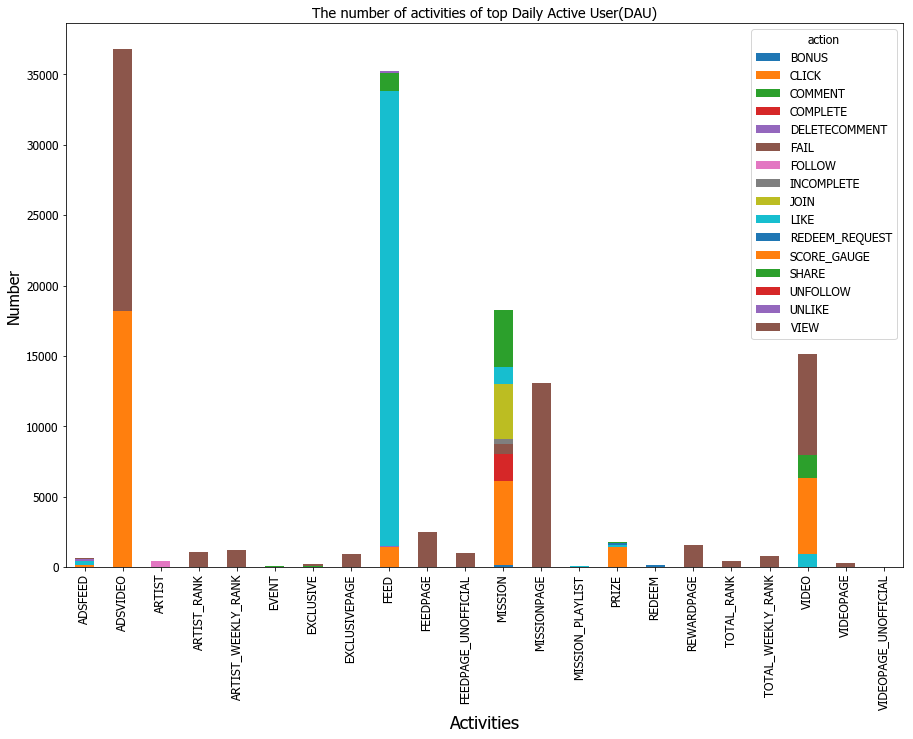

In [4]:
#Grouping DAU transaction by objecttype and action features 
activities = mostDAU.groupby(['objecttype','action']).size().unstack()

font = {'family' : 'Tahoma',
        'size'   : 12}
plt.rc('font', **font)

activities.plot(kind='bar', stacked=True, figsize=[15,10],title="The number of activities of top Daily Active User(DAU)")
plt.xlabel('Activities', fontsize=18)
plt.ylabel('Number', fontsize=16)
plt.show()


## 3. Finding the most attractive artists for DAU


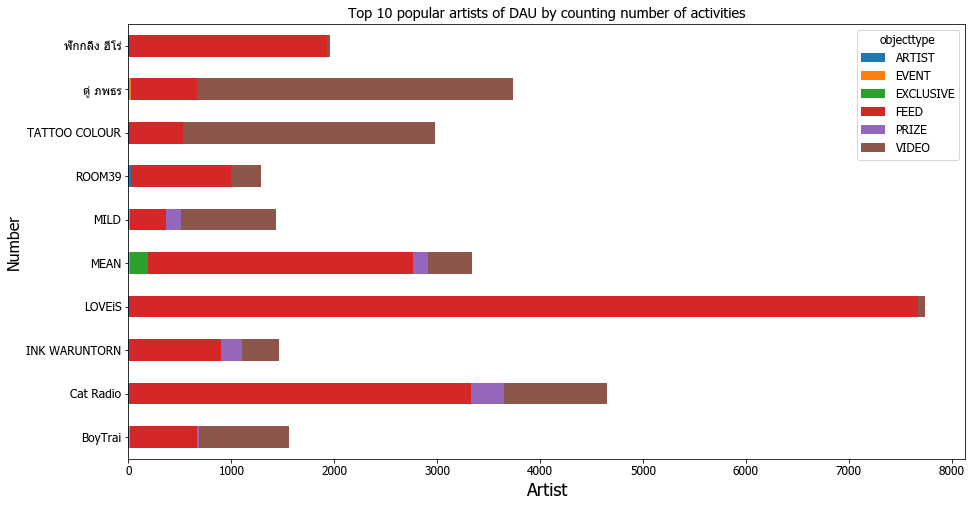

In [5]:
mostArtistDAU = mostDAU[np.isfinite(mostDAU['artistid'])]
mostArtistDAU = mostArtistDAU[['objecttype','artistid']]

#Fix scientific suppression number of artistid
pd.set_option('display.precision',13)

#Merges between DAU transaction and Artists table
mostArtistDAU = pd.merge(mostArtistDAU, artistDf, on='artistid')

#Finds top 10 popular artists from DAU transaction by counting number of activities related to artists
top10ArtistID = mostArtistDAU['artistid'].value_counts().index[0:10]

#Filtering the DAU transaction with only 10 popular artist
top10ArtistAct = mostArtistDAU.loc[mostArtistDAU['artistid'].isin(top10ArtistID)]

#Grouping DAU transaction by name and objecttype features in pandas and then plot with matplotlib
top10ArtistAct = top10ArtistAct.groupby(['name','objecttype']).size().unstack()
top10ArtistAct.plot(kind='barh', stacked=True, figsize=[15,8],title="Top 10 popular artists of DAU by counting number of activities")
plt.xlabel('Artist', fontsize=18)
plt.ylabel('Number', fontsize=16)
plt.show()
